In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
from collections import deque
import random

In [7]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 400

In [10]:
################################
# NN Q-learning implementation #
################################

env.reset()
observation_space = env.observation_space
action_space = env.action_space

torch.manual_seed(0)

loss = torch.nn.MSELoss()

nn_model = torch.nn.Sequential(
    torch.nn.Linear(4,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,2),
)

EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995
BATCH_SIZE = 32
GAMMA = 0.95

exploration_rate = 1
memory = deque(maxlen=1000000)

nn_model_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

def select_action(state):
    global exploration_rate
    
    if np.random.rand() < exploration_rate:
        return action_space.sample()
    state = torch.from_numpy(state.astype("float32")) 
    q_values = nn_model(state)
    return torch.argmax(q_values).item()

def remember(last_state,action,reward,next_state,done):
    global memory
    memory.append((last_state,action,reward,next_state,done))

def experience_replay():
    global memory,EXPLORATION_MIN,EXPLORATION_DECAY,BATCH_SIZE,GAMMA,exploration_rate

    if len(memory) < BATCH_SIZE:
        return

    batch = random.sample(memory,BATCH_SIZE)
    
    for last_state, action, reward, next_state, done in batch:
        q_update = reward
        if not done:
            q_update = (reward + GAMMA * torch.amax(nn_model(torch.from_numpy(next_state.astype("float32")))).item())
        q_values = nn_model(torch.from_numpy(last_state.astype("float32")))
        q_values[action] = q_update
        
        #fit
        l = loss(nn_model(torch.from_numpy(last_state.astype("float32"))), q_values)
        nn_model.zero_grad()
        l.backward()
        nn_model_optimizer.step()
    
    if exploration_rate > EXPLORATION_MIN:
        exploration_rate *= EXPLORATION_DECAY

Episode 0 finished after 20 steps with 18.0 total reward
Episode 1 finished after 18 steps with 16.0 total reward
Episode 2 finished after 22 steps with 20.0 total reward
Episode 3 finished after 25 steps with 23.0 total reward
Episode 4 finished after 14 steps with 12.0 total reward
Episode 5 finished after 11 steps with 9.0 total reward
Episode 6 finished after 11 steps with 9.0 total reward
Episode 7 finished after 17 steps with 15.0 total reward
Episode 8 finished after 17 steps with 15.0 total reward
Episode 9 finished after 23 steps with 21.0 total reward
Episode 10 finished after 22 steps with 20.0 total reward
Episode 11 finished after 22 steps with 20.0 total reward
Episode 12 finished after 34 steps with 32.0 total reward
Episode 13 finished after 71 steps with 69.0 total reward
Episode 14 finished after 74 steps with 72.0 total reward
Episode 15 finished after 64 steps with 62.0 total reward
Episode 16 finished after 92 steps with 90.0 total reward
Episode 17 finished after 

<function matplotlib.pyplot.show(close=None, block=None)>

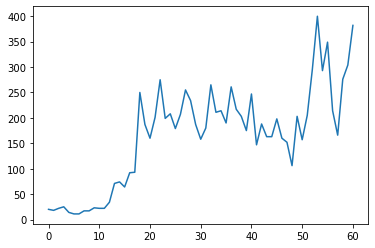

In [11]:
#training loop
episodes = 300
episodes_steps = np.array([])
num_solved = 0

for episode_i in range(episodes):
    last_state = env.reset()
    steps = 0
    total_reward = 0
    
    while True:
        env.render()
        steps += 1
        action = select_action(last_state)
        next_state, reward, done, info = env.step(action)
        reward = reward if not done else -reward
        remember(last_state,action,reward,next_state,done)
        experience_replay()
        
        total_reward += reward
        
        if done:
            print("Episode {} finished after {} steps with {} total reward".format(episode_i,steps,total_reward))
            if total_reward > 250:
                num_solved += 1
            break
    
        last_state = next_state
    
    episodes_steps = np.append(episodes_steps,steps)
    
    if num_solved > 10:
        break
        
env.close()

plt.plot(episodes_steps)
plt.show